# Inference

# Read Data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from urban_growth.estimator import *
from urban_growth.components import *
from itertools import product
import pandas as pd
import pickle
from scipy.special import expit
%matplotlib inline

In [2]:
years      = [1990, 2000, 2010, 2015]
throughput_dir = 'throughput/HCM'

plot_args = {'interpolation' : 'nearest', 'cmap' : 'Greys'}

In [3]:
def f(x, delim):
    path = throughput_dir + '/HCM_' + str(x) + '.txt'
    return np.loadtxt(path, dtype=int, delimiter=delim)

maps  = {year : f(year, ' ') for year in years}
geo = np.loadtxt(throughput_dir + '/HCM_geo.txt')

In [4]:
maps = {year : sum([maps[i] for i in years if i <= year]) for year in years}
for k in maps:
    maps[k][maps[k] > 1] = 1

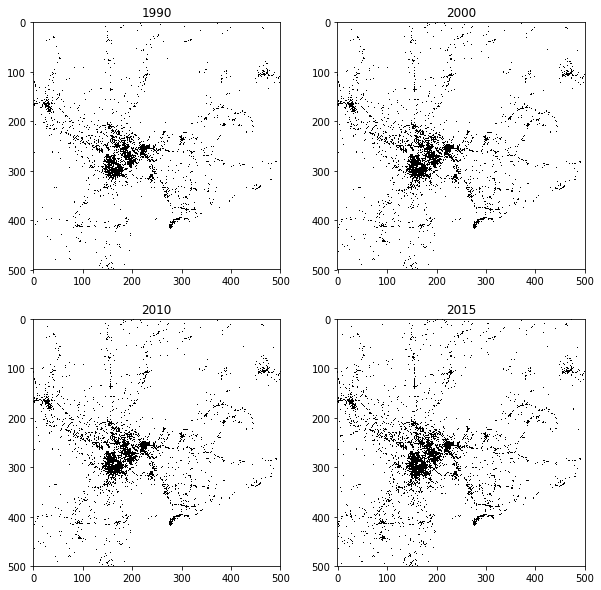

In [5]:
fig, axarr = plt.subplots(2, 2, figsize = (10, 10))
k = 0
for i, j in product(range(2), range(2)):
    axarr[i, j].imshow(maps[years[i + j]], **plot_args)
    axarr[i,j].set_title(years[k])
    k += 1

# Perform Inference

In [6]:
def grid_search(Y0, Y1):
   
    y0_vec= []
    y1_vec = []
    T_vec = []
    pars_hat_vec = []
    ll_vec = []
    h_inv_vec = []
    N_vec = []

    X = maps[Y1] - maps[Y0]
    X[X == -1] = 0          # ignore settlements that have been disbanded
    X = X * geo             # make consistent with geo mask
    X[maps[Y0]] = np.nan
    
    e = estimator(M0 = maps[Y0], geo = geo, model = 'logistic')
    e.update_morphology()
    e.make_dist_array()
    
#     for T in sorted(set(e.areas.values()))[1:]:
    for T in np.arange(2, 10):
        e.partition_clusters([T])
        e.partition_dist_array()
        pars_0 = {
            'alpha' : np.array([5, 8]),
            'gamma' : np.array([3.5, 2.8]), 
            'beta'  : np.array([-2])
           }

        pars_hat, ll_hat, h_inv = e.logistic_ML(X, 
                                        pars_0, 
                                        use_grad = True, 
                                        opts = {'disp' : True})
        
        y0_vec.append(Y0)
        y1_vec.append(Y1)
        T_vec.append(T)
        pars_hat_vec.append(pars_hat)
        ll_vec.append(ll_hat)
        h_inv_vec.append(h_inv)
        N_vec.append(np.sum(np.isfinite(X) * (geo > 0)))
                
        print T, pars_hat
        
    df = pd.DataFrame(
            {
                'Y0'       : y0_vec,
                'Y1'       : y1_vec,
                'T'        : T_vec,
                'pars_hat' : pars_hat_vec,
                'll'       : ll_vec,
                'h_inv'    : h_inv_vec,
                'N'        : N_vec
            }
        )
    return df
    

In [ ]:
out = pd.concat([grid_search(years[i], years[i+1]) for i in range(3)])
out_path = "throughput/HCM_estimates"
out_file = open(out_path,'wb')
pickle.dump(out,out_file)   
out_file.close()